How to run a stellar evolution code
====================

Here we will generate initial conditions for a stellar evolution code. We will adopt a parametrized stellar evolution code.

For reference you can read chapter 3 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate inital conditions (mass-function)
- how to run a parametrized stellar evolution code
- channels and data transfer
- plotting results

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units

We start by setting up a simulation by specifying the initial mass function. What would you say is the biggest difference between these IMFs?

mean-mass for Kroupa= 0.615508828404 MSun
mean-mass for Salpeter= 0.349947357756 MSun


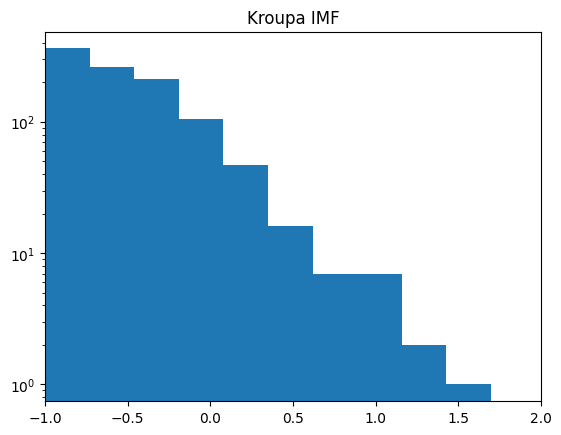

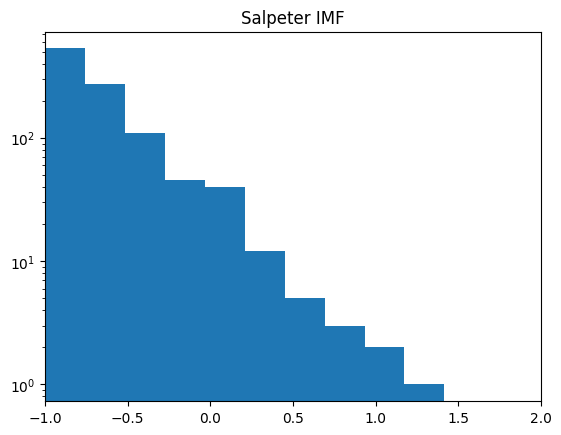

In [2]:
from amuse.datamodel import Particles
n_stars = 1024
mmin = 0.1 | units.MSun
mmax = 100 | units.MSun

from amuse.lab import new_kroupa_mass_distribution
mkroupa = new_kroupa_mass_distribution(n_stars,
                                           mass_min=mmin, 
                                           mass_max=mmax)
k_stars = Particles(mass=mkroupa)
from amuse.lab import new_salpeter_mass_distribution
msalpeter = new_salpeter_mass_distribution(n_stars, 
                                           mass_min=mmin, 
                                           mass_max=mmax)
s_stars = Particles(mass=msalpeter)
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

pyplot.hist(numpy.log10(k_stars.mass.value_in(units.MSun)))
pyplot.title('Kroupa IMF')
pyplot.yscale('log')
pyplot.xlim(-1, 2)
pyplot.figure()
pyplot.hist(numpy.log10(s_stars.mass.value_in(units.MSun)))
pyplot.title('Salpeter IMF')
pyplot.yscale('log')
pyplot.xlim(-1, 2)
pyplot.show()

Now that the mass functions are determined, we can evolve the stars in time. For this we start two stellar evolution codes, both parametrized, and evolve the stars in time.

In [3]:
from amuse.community.seba.interface import SeBa
def start_stellar_code(stars, metal):
    stellar = SeBa()
    stellar.parameters.metallicity = metal
    stellar.particles.add_particles(stars)
    channels = {"to_stars": stellar.particles.new_channel_to(stars), 
                "to_stellar": stars.new_channel_to(stellar.particles)}
    return stellar, channels
kstellar, kchannels = start_stellar_code(k_stars, 0.02)
sstellar, schannels = start_stellar_code(s_stars, 0.02)

Now the stellar evolution code are declared. Now evolve in time and calculate the mean mass as a function of time.

In [4]:
times = 10**numpy.arange(0.0, 4.0, 0.1) | units.Myr
mmean = []
L_tot_k = [] | units.LSun
T_L_weighted_k = [] | units.K
L_tot_s = [] | units.LSun
T_L_weighted_s = [] |units.K

for time in times:
    kstellar.evolve_model(time)
    kchannels["to_stars"].copy()
    L_tot_k.append(k_stars.luminosity.sum())
    upper_term_k = numpy.sum(k_stars.luminosity*k_stars.temperature)
    lower_term_k = k_stars.luminosity.sum()
    T_L_weighted_k.append(upper_term_k/lower_term_k)
    
    sstellar.evolve_model(time)
    schannels["to_stars"].copy()
    L_tot_s.append(s_stars.luminosity.sum())
    upper_term_s = numpy.sum(s_stars.luminosity*s_stars.temperature)
    lower_term_s = s_stars.luminosity.sum()
    T_L_weighted_s.append(upper_term_s/lower_term_s)
    
    mmean.append(numpy.mean(k_stars.mass)/numpy.mean(s_stars.mass))
kstellar.stop()
sstellar.stop()
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

mean-mass for Kroupa= 0.369650200333 MSun
mean-mass for Salpeter= 0.255705911102 MSun


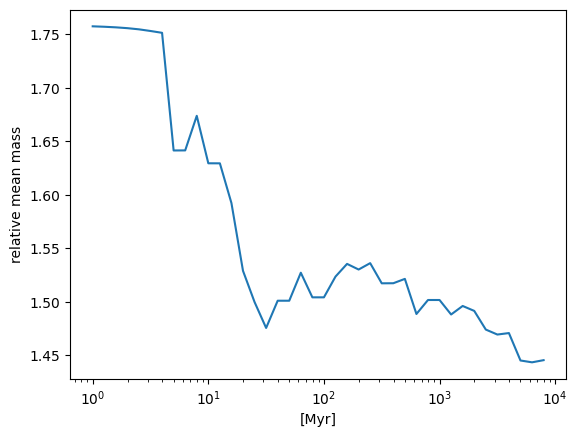

In [5]:
from amuse.plot import plot
plot(times, mmean)
pyplot.ylabel("relative mean mass")
pyplot.semilogx()
pyplot.show()

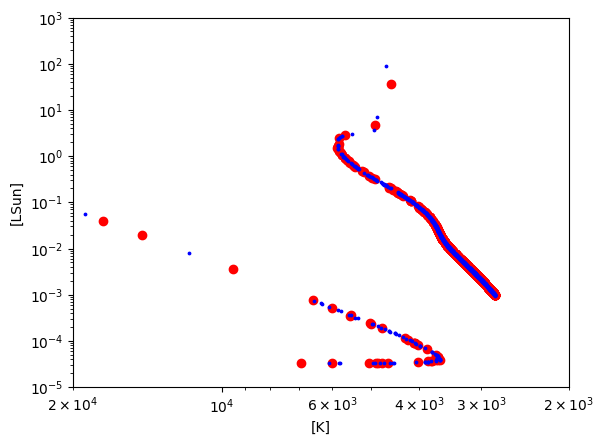

In [6]:
from amuse.plot import scatter
scatter(s_stars.temperature, s_stars.luminosity, c='r')
scatter(k_stars.temperature, k_stars.luminosity, c='b', s=3)
pyplot.xlim(2.e+4, 2000)
pyplot.ylim(1.e-5, 1000)
pyplot.loglog()
pyplot.show()

You have calculated the evolution of a stellar population with solar metalicity.

Assignments and questions:
---------------

### Assignment 1:
Run the notebook and describe the evolution of the relative mean stellar mass. Why does it drop with time?

### Assignment 2:
Compare the mean mass of two stellar populations with different metalicity, 0.02 (solar) and 0.002 (one tenth times solar) but the same stellar masses.

### Question 1:
Is there a difference in the number of compact objects (white dwarfs, neutron stars, black holes; these types are defined [here](https://github.com/amusecode/amuse/blob/main/src/amuse/units/units.py), and e.g. 1.|stellar_type corresponds to a main sequene star) in the populations with different initial mass functions, and with different metallicities, and is this difference statistically significant?

Is a similar difference also noticeable in the number of main sequence stars?

### Assignment 3:
Calculate, instead of the mean mass, the total luminosity and luminosity-weighted temperature ($T_{LW}=(\Sigma_iL_iT_i)/(\Sigma_iL_i)$, the effective color of the integrated stellar population) of the entire population of stars as a function of time.

Make a plot of these parameters for both mass functions, and both metallicities. 

### Question 4:
Can one, based on observational differences in luminosity and integrated temperature, make a distinction between the two mass functions?

### Assignment 1

It stays stable for some time, then it will be higher and it drops at the end. The relative mean stellar mass will drop at the end, so in the end the mean mass of saltepeter distribution will gain more mass than the kroupa distribution. For kroupa there will be more white dwarfs at the end, which have radiated away mass, which can be seen in the final figure.

### Assignment 2

In [7]:
n_stars = 1024
mmin = 0.1 | units.MSun
mmax = 100 | units.MSun

stars_002 = Particles(mass=mkroupa)
    
stellar_002, channels_002 = start_stellar_code(stars_002, 0.0002)

times = 10**numpy.arange(0.0, 4.0, 0.1) | units.Myr

L_tot_002 = [] | units.LSun
T_L_weighted_002 = [] | units.K

for time in times:
    stellar_002.evolve_model(time)
    channels_002["to_stars"].copy()

    L_tot_002.append(stars_002.luminosity.sum())
    upper_term_002 = numpy.sum(stars_002.luminosity*stars_002.temperature)
    lower_term_002 = stars_002.luminosity.sum()
    T_L_weighted_002.append(upper_term_002/lower_term_002)

stellar_002.stop()

print("mean-mass for Kroupa with z=0.02 is", numpy.mean(k_stars.mass))
print("mean-mass for Kroupa with z=0.002 is", numpy.mean(stars_002.mass))

mean-mass for Kroupa with z=0.02 is 0.369650200333 MSun
mean-mass for Kroupa with z=0.002 is 0.393662773459 MSun


### Question 1

In [8]:
def types(stars):
    MS = numpy.sum(numpy.array(stars.stellar_type.number) == 1)
    WD = numpy.sum(numpy.array(stars.stellar_type.number) == 10) + numpy.sum(numpy.array(stars.stellar_type.number) == 11) + numpy.sum(numpy.array(stars.stellar_type.number) == 12)
    NS = numpy.sum(numpy.array(stars.stellar_type.number) == 13)
    BH = numpy.sum(numpy.array(stars.stellar_type.number) == 14)
    return MS, WD, NS, BH

In [9]:
MS_002, WD_002, NS_002, BH_002 = types(stars_002)
MS_k, WD_k, NS_k, BH_k = types(k_stars)
MS_s, WD_s, NS_s, BH_s = types(s_stars)

print("For the kroupa dist with z=0.002 there are {} Main Sequence stars, {} White Dwarfs, {} Neutron Stars and {} Black Holes".format(MS_002, WD_002, NS_002, BH_002))
print("For the kroupa dist with z=0.02 there are {} Main Sequence stars, {} White Dwarfs, {} Neutron Stars and {} Black Holes".format(MS_k, WD_k, NS_k, BH_k))
print("For the saltpeter dist with z=0.02 there are {} Main Sequence stars, {} White Dwarfs, {} Neutron Stars and {} Black Holes".format(MS_s, WD_s, NS_s, BH_s))

For the kroupa dist with z=0.002 there are 916 Main Sequence stars, 94 White Dwarfs, 10 Neutron Stars and 3 Black Holes
For the kroupa dist with z=0.02 there are 938 Main Sequence stars, 72 White Dwarfs, 7 Neutron Stars and 3 Black Holes
For the saltpeter dist with z=0.02 there are 982 Main Sequence stars, 37 White Dwarfs, 2 Neutron Stars and 1 Black Holes


In [30]:
from scipy import stats

#DOES NOT WORK
#print("The KS test for the eccentricities is:",stats.kstest(cdf_stars_002, cdf_k_stars))
#print("The KS test for the formation times is:",stats.kstest(k_stars,s_stars))

The Saltpeter dist has more main sequence stars than the ones with the Kroupa dist. For lower metallicity stars, there are more white dwarfs. This is logical, as lower metallicity stars have formed longer ago and thus are older and more will have become a White Dwarf etc.

### Assignment 3

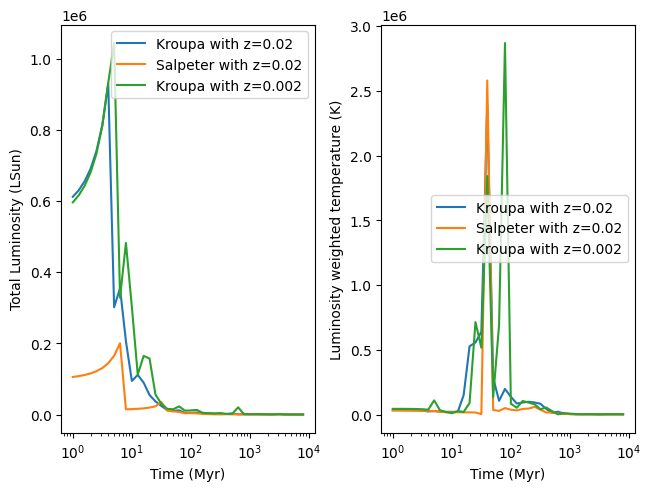

In [39]:
fig, axs = pyplot.subplots(1, 2, layout='constrained')#, sharey='row', sharex="col")

axs[0].plot(times.value_in(units.Myr), L_tot_k.value_in(units.LSun), label="Kroupa with z=0.02")
axs[0].plot(times.value_in(units.Myr), L_tot_s.value_in(units.LSun), label="Salpeter with z=0.02")
axs[0].plot(times.value_in(units.Myr), L_tot_002.value_in(units.LSun), label="Kroupa with z=0.002")
axs[0].set_ylabel("Total Luminosity (LSun)")
axs[0].set_xlabel("Time (Myr)")
axs[0].semilogx()
axs[0].legend()

axs[1].plot(times.value_in(units.Myr), T_L_weighted_k.value_in(units.K), label="Kroupa with z=0.02")
axs[1].plot(times.value_in(units.Myr), T_L_weighted_s.value_in(units.K), label="Salpeter with z=0.02")
axs[1].plot(times.value_in(units.Myr), T_L_weighted_002.value_in(units.K), label="Kroupa with z=0.002")
axs[1].set_ylabel("Luminosity weighted temperature (K)")
axs[1].set_xlabel("Time (Myr)")
axs[1].semilogx()
axs[1].legend()

### Question 4

Yes, based on the Total Luminosity between distributions and metallicity based on total temperature weighted luminosity